---
# KT, 지니랩스
---
```
Test 1
data_size = 20 * 50
w,h,c = 32,32,1
batch = 128
epoch = 100
```

In [1]:
# 기본
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import math
import os
import shutil
import glob # 특정 폴더에 하위 폴더 및 파일 목록을 다 가져오는 모듈
import cv2

# 경고 뜨지 않게 ..
import warnings
warnings.filterwarnings('ignore')

# 출력한 내용 청소
from IPython.display import clear_output

# 그래프 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['figure.figsize'] = 20, 10
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['text.color'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['xtick.labelcolor'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plt.rcParams['ytick.labelcolor'] = 'white'
plt.rcParams['legend.labelcolor'] = 'white'
plt.rcParams['legend.facecolor'] = 'grey'


# 랜덤 모듈
import random

# 학습 모델 저장 및 복원
import pickle

# 딥러닝 라이브러리
import tensorflow as tf
# 신경망 모델을 관리하는 객체
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 선형 회귀 레이어
from tensorflow.keras.layers import Dense
# 활성화 함수를 정의하는 객체
from tensorflow.keras.layers import Activation
# 원핫 인코딩을 수행하는 함수
from tensorflow.keras.utils import to_categorical
# 모델을 자동 저장한다.
from tensorflow.keras.callbacks import ModelCheckpoint
# 성능이 더이상 좋아지지 않을 경우 중단 시킨다.
from tensorflow.keras.callbacks import EarlyStopping
# GPU 사용 확인
from tensorflow.python.client import device_lib
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout

# 평가함수
# 분류용
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# 회귀용
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# 표준화
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# 문자열 -> 숫자
from sklearn.preprocessing import LabelEncoder

# 전체데이터를 학습용과 검증으로 나눈다.
from sklearn.model_selection import train_test_split, KFold

# ★매우 중요★
# 현재 프로젝트에서 GPU 메모리 사용을 필요한 만큼만 쓸 수 있도록 한다.
# 컴퓨터에 있는 GPU 정보들을 가져온다.
# gpu가 있다면...

os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

In [2]:
# CNN : 커널을 통해 합성곱을 구하는 것. 이미지의 특징이 두드러 지게 한다.
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv1D

# MaxPooling : 커널내에서 가장 큰 값을 추출하는 방식으로 불필요한 부분을 제거한다.
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import MaxPool1D

# Flatten : 다차원의 이미지 데이터를 선형 회귀 은닉층으로 전달하기 전에
# 1차원으로 변환하는 것
from tensorflow.keras.layers import Flatten

# Dropout : 이미지나 영상, 음파 등의 데이터는 오랫동안 학습을 진행 시켜야 한다.
# 하지만 너무 빨리 과적합이 발생되면 조기 중단 때문에 학습 횟수가 줄어들 수 있다.
# 이에 은닉의 노드를 일부 사용하지 않으므로써 과적합이 빨리 오는 것을 예방하고
# 오랫동한 학습이 진행될 수 있도록 한다.
from tensorflow.keras.layers import Dropout

In [3]:
# 이미지 파일을 지정하여 이미지 데이터를 읽어온다.
from PIL import Image

In [4]:
# 하위 폴더 들의 이름을 가져온다(결과 데이터)
categories = list(os.walk('./train/'))[0][1]  # [0] 폴더목록, [0][1] 폴더목록 내 하위폴더

In [5]:
categories

['가자미전',
 '간장게장',
 '감자탕',
 '거봉포도',
 '고구마',
 '고구마맛탕',
 '고등어찌개',
 '곱창구이',
 '군만두',
 '굴전',
 '김치찌개',
 '깻잎나물볶음',
 '꼬리곰탕',
 '꽈리고추무침',
 '나시고랭',
 '누룽지',
 '단무지',
 '달걀말이',
 '달걀볶음밥',
 '달걀비빔밥',
 '닭가슴살',
 '닭개장',
 '닭살채소볶음',
 '닭칼국수',
 '도가니탕',
 '도토리묵',
 '돼지감자',
 '돼지고기구이',
 '두부',
 '두부고추장조림',
 '딸기',
 '떡갈비',
 '떡국',
 '레드와인',
 '마늘쫑무침',
 '마카롱',
 '매운탕',
 '미소된장국',
 '미소장국',
 '미역초무침',
 '바나나우유',
 '바지락조개국',
 '보리밥',
 '불고기',
 '비빔밥',
 '뼈해장국',
 '삼선자장면',
 '새우매운탕',
 '새우볶음밥',
 '생연어']

In [6]:
num_classes = len(categories)

In [7]:
# image size
image_w = 256
image_h = 256
channel = 3

pixels = image_w * image_h * channel

In [8]:
X = []
y = []

for idx, category in enumerate(categories):
    # one-hot
    label = [0 for i in range(num_classes)]
    label[idx] = 1
    
    image_dir = './train/' + category
    files = glob.glob(image_dir + './*.jpg')
    
    for i, j in enumerate(files):
        img = Image.open(j)
        # img = img.convert("L")
        img = img.resize((image_w, image_h))
        data = np.asarray(img) / 255
        
        X.append(data)
        y.append(label)
        
        if i % 700 == 0 :
            print(category, ':', j)
        
X = np.array(X)
y = np.array(y)

가자미전 : ./train/가자미전.\07_071_07011001_160325962319321_1_1.jpg
간장게장 : ./train/간장게장.\13_131_13011001_160283198137567_1.jpg
감자탕 : ./train/감자탕.\04_043_04013003_160310320495791_0_1.jpg
거봉포도 : ./train/거봉포도.\A220102XX_00879_0.jpg
고구마 : ./train/고구마.\A240101XX_03067_0.jpg
고구마맛탕 : ./train/고구마맛탕.\10_104_10014002_160327656232685_0_1.jpg
고등어찌개 : ./train/고등어찌개.\04_045_04015001_160453924457830_1_1.jpg
곱창구이 : ./train/곱창구이.\Img_003_0001.jpg
군만두 : ./train/군만두.\02_022_02012002_160280303753582_1.jpg
굴전 : ./train/굴전.\07_071_07011002_160290610355083_0_1.jpg
김치찌개 : ./train/김치찌개.\B060103XX_10290_0.jpg
깻잎나물볶음 : ./train/깻잎나물볶음.\08_082_08012003_160284014319714_1.jpg
꼬리곰탕 : ./train/꼬리곰탕.\04_043_04013006_160415840746190_1_1.jpg
꽈리고추무침 : ./train/꽈리고추무침.\Img_062_0002.jpg
나시고랭 : ./train/나시고랭.\B010411_10388_0.jpg
누룽지 : ./train/누룽지.\Img_071_0002.jpg
단무지 : ./train/단무지.\13_131_13011012_160273723268904_1.jpg
달걀말이 : ./train/달걀말이.\07_074_07014001_160274615545634_1.jpg
달걀볶음밥 : ./train/달걀볶음밥.\B010419XX_11393_0.jpg
달걀비빔밥 : ./tr

In [9]:
data.shape

(256, 256, 3)

In [10]:
X.shape, y.shape

((10000, 256, 256, 3), (10000, 50))

In [11]:
# 다중 분류 옵션들
out_nodes = len(categories)
loss_function = 'categorical_crossentropy'
activation_function = 'softmax'

In [12]:
# 신경망 설계
model = Sequential()

# CNN : 이미지 데이터를 입력받아 합성곱을 수행한다.
# 첫 번째 매개변수 : 노드의 개수 = 커널의 개수
# kernel_size : 커널 하나의 가로, 세로 길이 2*2 or 3*3 추천
# input shape : 입력되는 이미지의 세로길이 가로길이 채널 수
model.add(Conv2D(32, kernel_size = (3,3), input_shape = (image_h, image_w, channel)))
model.add(Activation('LeakyReLU'))

model.add(Conv2D(64, kernel_size = (3,3)))
model.add(Activation('LeakyReLU'))

# 커널 내에서 가장 큰 값만 추출하여 불필요한 부분을 제거한다.
model.add(MaxPool2D(pool_size = 2))

# 과적합 방지
model.add(Dropout(0.25))

# 다차원의 이미지 데이터를 1차원으로 변환
model.add(Flatten())

# CNN 층을 통해 변형된 이미지 데이터를 학습하는 선형 회귀층
model.add(Dense(128))
model.add(Activation('LeakyReLU'))

model.add(Dropout(0.5))

# 출력층
model.add(Dense(out_nodes))
model.add(Activation(activation_function))

In [18]:
# 모델 컴파일
# lr = 0.001
adam = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss = loss_function, optimizer = adam, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 activation (Activation)     (None, 254, 254, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 252, 252, 64)      18496     
                                                                 
 activation_1 (Activation)   (None, 252, 252, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 126, 126, 64)      0         
                                                        

```
# 만약 폴더가 있다면 삭제한다.
if os.path.isdir(path) :
    shutil.rmtree(path)
    
# 폴더를 생성한다.
os.makedirs(os.path.join(path))
```

# 모델_체크포인트 문법
path1 = path + '/{epoch}-{val_loss}.h5'
path2 = path + '/best_model.h5'

# 저장 콜백
call1 = ModelCheckpoint(filepath = path1, monitor = 'val_loss', save_best_only = True) # 이미지 작업에선 빼도된다. 용량주의
call2 = ModelCheckpoint(filepath = path2, monitor = 'val_loss', save_best_only = True)

# 조기 중단
call3 = EarlyStopping( monitor = 'val_loss', patience = 50 )

In [19]:
class Dataloader(Sequence):

    def __init__(self, x_set, y_set, batch_size, shuffle=False):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)
        
        
    def __getitem__(self, idx):
        indices = self.indices[idx * self.batch_size : (idx + 1) * self.batch_size]

        batch_x = [self.x[i] for i in indices]
        batch_y = [self.y[i] for i in indices]

        return np.array(batch_x), np.array(batch_y)

    def on_epoch_end(self):
        self.indices = np.arange(len(self.x))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

In [20]:
def fold(self):
    self.kfold = KFold(n_splits = 5, shuffle = True, random_state = 1)
    self.cross_val_score(model, X, Y, cv=kfold)

In [21]:
train_loader = Dataloader(X, y, 128, shuffle=True)
valid_loader = Dataloader(X, y, 128)
test_loader = Dataloader(X, y, 128)

In [22]:
history = model.fit(train_loader, validation_data=valid_loader, epochs=100, workers=4, validation_split= 0.2,
                   # callbacks= [call1, call2, call3]
                   )

Epoch 1/100


ResourceExhaustedError: Graph execution error:

Detected at node 'sequential/activation/leaky_re_lu/LeakyRelu' defined at (most recent call last):
    File "C:\Users\245\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\245\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\245\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\245\AppData\Local\Programs\Python\Python310\lib\site-packages\traitlets\config\application.py", line 976, in launch_instance
      app.start()
    File "C:\Users\245\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\245\AppData\Local\Programs\Python\Python310\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\245\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 600, in run_forever
      self._run_once()
    File "C:\Users\245\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1896, in _run_once
      handle._run()
    File "C:\Users\245\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\245\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\245\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\245\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\245\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\245\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "C:\Users\245\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\245\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "C:\Users\245\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "C:\Users\245\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\245\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\245\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\245\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\245\AppData\Local\Temp\ipykernel_14008\981943307.py", line 1, in <cell line: 1>
      history = model.fit(train_loader, validation_data=valid_loader, epochs=100, workers=4, validation_split= 0.2,
    File "C:\Users\245\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\245\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\245\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "C:\Users\245\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\245\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "C:\Users\245\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\245\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\245\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\245\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\245\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\245\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\245\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "C:\Users\245\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py", line 458, in call
      return self._run_internal_graph(
    File "C:\Users\245\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\245\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\245\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\245\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\245\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\layers\core\activation.py", line 57, in call
      return self.activation(inputs)
    File "C:\Users\245\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\245\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\245\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\245\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\layers\activation\leaky_relu.py", line 70, in call
      return backend.relu(inputs, alpha=self.alpha)
    File "C:\Users\245\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py", line 4975, in relu
      return tf.nn.leaky_relu(x, alpha=alpha)
Node: 'sequential/activation/leaky_re_lu/LeakyRelu'
OOM when allocating tensor with shape[128,32,254,254] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential/activation/leaky_re_lu/LeakyRelu}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_1629]

In [ ]:
# 정확도 확인 ( 앞선 결과에 누적되었다 )
a1 = model.evaluate(test_loader)
print(f' 손실률 : {a1[0]}')
print(f' 정확도 : {a1[1]}')

In [ ]:
model.save('./model/one/best_model.h5')

In [ ]:
# 리스트를 추출한다.
loss_list = history.history['loss']
accuracy_list = history.history['accuracy']
val_loss_list = history.history['val_loss']
val_accuracy_list = history.history['val_accuracy']

In [ ]:
# 정확도 그래프
plt.plot(accuracy_list, label='accuracy')
plt.plot(val_accuracy_list, label='val_accuracy')
plt.legend()
plt.show()

In [ ]:
# 손실률
plt.plot(loss_list, label='loss')
plt.plot(val_loss_list, label='val_loss')
plt.legend()
plt.show()

# 테스트

# 모델불러오기
from tensorflow.keras.models import load_model
best_model = load_model('./model/zero/best_model.h5')

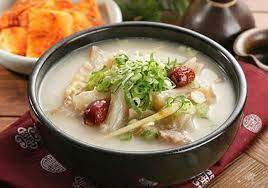

In [181]:
# 원본이미지
test_org = Image.open('./random_sample/도가니탕1호.jpg')
test_org

In [182]:
# 흑백반전
# test_img = test_org.convert('L')
# test_img

In [183]:
# # 리사이징
# test_img = test_org.resize((image_w, image_h))
# test_img

In [184]:
test_data = np.asarray(test_org) / 255

In [185]:
# 이미지 변경시 값 변화 확인
print(test_data[0][0])

[0.84705882 0.80784314 0.77254902]


In [186]:
# 텐서로 변환
test_data = tf.reshape(test_data,(1, image_w, image_h, 3)) # 차원체크
test_data.shape

InvalidArgumentError: Input to reshape is a tensor with 151152 values, but the requested shape has 196608 [Op:Reshape]

In [29]:
# 예측한다.
pred = model.predict(test_data)
pred = pred * 255
pred.astype(int)

ValueError: in user code:

    File "C:\Users\245\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1845, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\245\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1834, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\245\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1823, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\245\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1791, in predict_step
        return self(x, training=False)
    File "C:\Users\245\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\245\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 256, 256, 3), found shape=(None, 268, 3)


In [ ]:
# 답을 출력한다.
test_org

In [ ]:
categories[np.argmax(pred)],np.argmax(pred)

In [61]:
# 검증용 샘플 랜덤 추출
r_sample_dir = './random_sample'
r_sample_files = glob.glob(r_sample_dir + './*.jpg')
r_sample_files

['./random_sample.\\가자미1호.jpg',
 './random_sample.\\게장1호.jpg',
 './random_sample.\\김치찌개1호.jpg',
 './random_sample.\\누룽지1호.jpg',
 './random_sample.\\도가니탕1호.jpg',
 './random_sample.\\떡국1호.jpg',
 './random_sample.\\생연어1호.jpg']

In [174]:
z = []

for k in files:
        img = Image.open(k)
        # img = img.convert("L")
        img = img.resize((256, 256))
        data = np.asarray(img) /255
        
        z.append(data)
        
z = np.array(z)

In [1]:
# 배열로 이미지 생성 - 배열 행의 평균을 필터로 설정 > 음식 이미지에 중첩됨
import cv2

cv2.imshow("image", np.average(z, axis = 0))
cv2.waitKey(0)
cv2.destroyAllWindows()

NameError: name 'np' is not defined

In [176]:
# 배열로 이미지 생성 - 기존 이미지
import cv2

cv2.imshow("image", z[1])
cv2.waitKey(0)
cv2.destroyAllWindows()

In [179]:
# 배열로 이미지 생성 - 배열 행의 평균을 제곱함
import cv2

cv2.imshow("image", z[1] ** np.average(z, axis = 0))
cv2.waitKey(0)
cv2.destroyAllWindows()

In [180]:
# 배열로 이미지 생성 - 1에서 배열 행의 평균을 뺀 수치를 제곱함
import cv2

cv2.imshow("image", (z[1]) ** (1 - np.average(z, axis = 0)))
cv2.waitKey(0)
cv2.destroyAllWindows()

# 제곱했을때 더욱 명확해진다.

In [ ]:
np.average(z, axis = 0)